In [148]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

## Function to get the venues using foursquare API

In [149]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'L2XUYCRD44VP2YBDMZ3XY0Z4XKO1JODM5SMG3IIYRZ5330FD' # your Foursquare ID
    CLIENT_SECRET = '5KI00FG4RT2VJQTIDPXFY1N4AOKTIXLIZEAO0AHPP3DPD0U1' # your Foursquare Secret
    VERSION = '20202601' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

## Function to get the details of all the venues

In [150]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'L2XUYCRD44VP2YBDMZ3XY0Z4XKO1JODM5SMG3IIYRZ5330FD' # your Foursquare ID
    CLIENT_SECRET = '5KI00FG4RT2VJQTIDPXFY1N4AOKTIXLIZEAO0AHPP3DPD0U1' # your Foursquare Secret
    VERSION = '20202601' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

## Function to get all Neighborhoods and Boroughs in NYC

In [151]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [152]:
#Display the data
nyc_data=get_new_york_data()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [156]:
# A data frame consisting of the number of neighborhood each borough has
df= nyc_data.groupby(['Borough']).agg({'Neighborhood': ['count']})
df.columns=['Neighborhoods']
df = df.reset_index()
df.head()

,Borough,Neighborhoods
0,Bronx,52
1,Brooklyn,70
2,Manhattan,40
3,Queens,81
4,Staten Island,63


## A pie chart to display Distribution of neighborhoods across borough

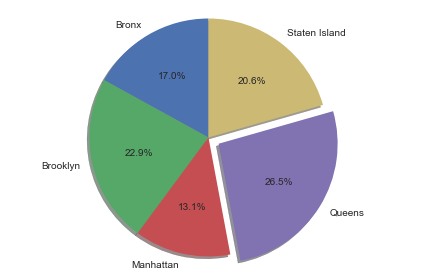

In [154]:
# Pie chart
labels = df['Borough']
values = df['Neighborhoods']
explode = (0, 0, 0, 0.1,0)  
fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Finding neighborhoods that contain italian resturants

In [157]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(nyc_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:1
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
( 10 / 306 ) Italian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Resturants in Baychester, Bronx:2
( 12 / 306 ) Italian Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Resturants in City Island, Bronx:3
( 14 / 306 ) Italian Resturants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Resturants in University Heights, Bronx:0
( 16 / 306 ) Italian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Resturants in Fordham, Bronx:9
( 18 / 306 ) Italian Resturants in East Tremont, Bronx:

( 141 / 306 ) Italian Resturants in Sunnyside, Queens:2
( 142 / 306 ) Italian Resturants in East Elmhurst, Queens:1
( 143 / 306 ) Italian Resturants in Maspeth, Queens:2
( 144 / 306 ) Italian Resturants in Ridgewood, Queens:3
( 145 / 306 ) Italian Resturants in Glendale, Queens:1
( 146 / 306 ) Italian Resturants in Rego Park, Queens:1
( 147 / 306 ) Italian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Italian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Italian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Italian Resturants in College Point, Queens:0
( 151 / 306 ) Italian Resturants in Whitestone, Queens:4
( 152 / 306 ) Italian Resturants in Bayside, Queens:3
( 153 / 306 ) Italian Resturants in Auburndale, Queens:2
( 154 / 306 ) Italian Resturants in Little Neck, Queens:6
( 155 / 306 ) Italian Resturants in Douglaston, Queens:5
( 156 / 306 ) Italian Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Italian Resturants in Bellerose, Queens:2
( 158 / 306 ) Italian Resturants

( 276 / 306 ) Italian Resturants in Stuyvesant Town, Manhattan:3
( 277 / 306 ) Italian Resturants in Flatiron, Manhattan:3
( 278 / 306 ) Italian Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Italian Resturants in Blissville, Queens:0
( 280 / 306 ) Italian Resturants in Fulton Ferry, Brooklyn:2
( 281 / 306 ) Italian Resturants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Italian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Italian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Italian Resturants in Dumbo, Brooklyn:2
( 285 / 306 ) Italian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Italian Resturants in Willowbrook, Staten Island:1
( 287 / 306 ) Italian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Italian Resturants in Egbertville, Staten Island:1
( 289 / 306 ) Italian Resturants in Roxbury, Queens:0
( 290 / 306 ) Italian Resturants in Homecrest, Brooklyn:1
( 291 / 306 ) Italian Resturants in Middle Village, Queens:1
( 292 / 306 ) Itali

In [140]:
#display the dataframe that contains intalian restaurants in NYC
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's
4,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden


## A barplot to show that number of italian restaurants present in each borough

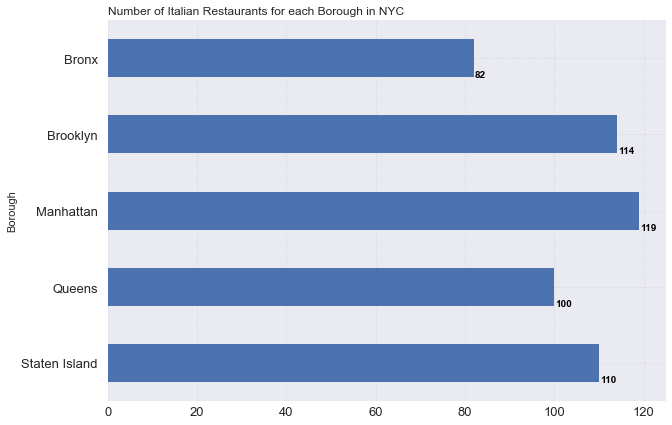

In [141]:
ax = italian_rest_ny.groupby('Borough')['Name'].count().plot(kind='barh', figsize=(10,7), fontsize=13);

# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 
  
# Add x, y gridlines 
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5, 
        alpha = 0.2) 
  
# Show top values  
ax.invert_yaxis() 
  
# Add annotation to bars 
for i in ax.patches: 
    plt.text(i.get_width()+0.2, i.get_y()+0.5,  
             str(round((i.get_width()), 2)), 
             fontsize = 10, fontweight ='bold', 
             color ='black') 

# Add Plot Title 
ax.set_title('Number of Italian Restaurants for each Borough in NYC', 
             loc ='left', ) 
plt.show()

In [142]:
#A dataframe that shows number of italian restaurant chains in NYC 

df1= italian_rest_ny.groupby(['Name']).agg({'Name': ['count']})
df1.columns=['Franchisees']
df1 = df1.reset_index()
df1.sort_values(by=['Franchisees'], inplace=True, ascending=False)
df2 = df1.head(10)
df2.head(10)

,Name,Franchisees
238,Pastosa Ravioli,5
102,Enzo's,5
123,Fumo,5
300,The Meatball Shop,4
216,Noodle Pudding,4
254,Plum Tomatoes,3
31,Beebe’s,3
50,Cafe Luna,3
240,Patricia's,3
241,Patricia's of Tremont,3


## A barplot to show the most famous italian restaurant chains in NYC

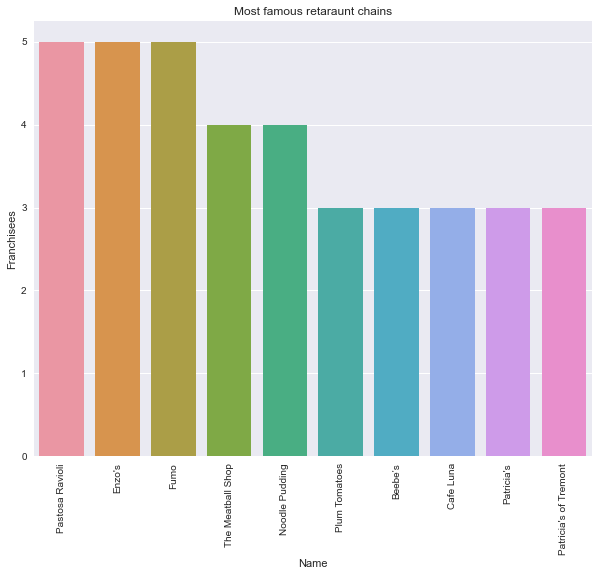

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
 
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'Name',
            y = 'Franchisees',
            data = df2)

plt.xticks(rotation=90)
plt.title('Most famous retaraunt chains')

# Show the plot
plt.show()

## Finding neighborhood list that contains italian resturants Along with its ratings, likes and tips paid

In [144]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 1 / 525 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 2 / 525 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.6    14
( 3 / 525 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.4     6
( 4 / 525 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.4     8
( 5 / 525 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96ae65317a593d837017f  Enzo's     29     8.8    11
( 6 / 525 ) processed
                         ID        Name  Likes  Rating  Tips
0  4b10591af964

                         ID       Name  Likes  Rating  Tips
0  4a8e261cf964a5201c1220e3  Roberto's     66     8.4    23
( 53 / 525 ) processed
                         ID        Name  Likes  Rating  Tips
0  4bc22a22920eb713bcc51b2c  Tra Di Noi     46     7.9    14
( 54 / 525 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4aa425bef964a5208e4520e3  Dominick's Restaurant    101     8.0    37
( 55 / 525 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b5bc595f964a520431529e3  Pasquale Riggaletto's     33     7.9    18
( 56 / 525 ) processed
                         ID                    Name  Likes  Rating  Tips
0  53ff939c498e6b601dfa3979  San Gennaro Ristorante     17     7.7     1
( 57 / 525 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 58 / 525 ) processed
                         ID       Name  Like

                         ID         Name  Likes  Rating  Tips
0  5e4567fa2eafa100085e9ec3  Bar Camillo     17     9.0     3
( 105 / 525 ) processed
                         ID        Name  Likes  Rating  Tips
0  4be30f9dd27a20a1cd1f915b  River Deli    302     8.9   100
( 106 / 525 ) processed
                         ID            Name  Likes  Rating  Tips
0  3fd66200f964a520ece81ee3  Noodle Pudding    222     8.1    87
( 107 / 525 ) processed
                         ID   Name  Likes  Rating  Tips
0  5a0740a3e1f22816d11723d5  Lillo     51     9.1     9
( 108 / 525 ) processed
                         ID      Name  Likes  Rating  Tips
0  5044f749e4b0dd909d2cc123  Table 87    109     8.1    39
( 109 / 525 ) processed
                         ID   Name  Likes  Rating  Tips
0  5a0740a3e1f22816d11723d5  Lillo     51     9.1     9
( 110 / 525 ) processed
                         ID    Name  Likes  Rating  Tips
0  593329652632ec0582bd71df  Popina     49     7.9    14
( 111 / 525 ) processed


                         ID      Name  Likes  Rating  Tips
0  4b467ca0f964a5206d2226e3  Il Posto     14     7.3     4
( 159 / 525 ) processed
                         ID Name  Likes  Rating  Tips
0  52b90597498ed57b85609429  Lea    118     7.9    34
( 160 / 525 ) processed
                         ID                Name  Likes  Rating  Tips
0  4c267153b012b71350e30893  Landi's Pork Store     32     8.5    11
( 161 / 525 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c2bbd1b2219c9288312a548  Pastosa Ravioli      6     7.2     1
( 162 / 525 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b467ca0f964a5206d2226e3  Il Posto     14     7.3     4
( 163 / 525 ) processed
                         ID        Name  Likes  Rating  Tips
0  5698109e498eb4e676c57b75  Dolce Vita      6     6.3     2
( 164 / 525 ) processed
                         ID           Name  Likes  Rating  Tips
0  58eac71c0319b80a65d5045b  Ammazza Caffe     79     9.

                         ID               Name  Likes  Rating  Tips
0  54961b98498eccc96c4a93d7  Masseria dei Vini    108     8.6    30
( 213 / 525 ) processed
                         ID  Name  Likes  Rating  Tips
0  548a64ae498e972164140a84  Parm    373     8.5    75
( 214 / 525 ) processed
                         ID     Name  Likes  Rating  Tips
0  4b69b408f964a520c5ae2be3  Noi Due     39     7.9    26
( 215 / 525 ) processed
                         ID                Name  Likes  Rating  Tips
0  4dcae1b18877502200c95822  Sergimmo Salumeria    326     8.8   129
( 216 / 525 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bbb9caaafe1b7139a6b2f4b  Mercato    316     8.1   126
( 217 / 525 ) processed
                         ID    Name  Likes  Rating  Tips
0  505b7061e4b0571999fb3da8  Tavola    258     8.2    70
( 218 / 525 ) processed
                         ID            Name  Likes  Rating  Tips
0  506e48ffe4b078ebe1c30a29  Bocca Di Bacco    106     8.0   

                         ID           Name  Likes  Rating  Tips
0  5d4861420372ce0007e23375  Maestro Pasta     10     8.2     5
( 268 / 525 ) processed
                         ID            Name  Likes  Rating  Tips
0  4bb54fe02f70c9b6c6188430  Giardino D'oro     35     8.0    18
( 269 / 525 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4a4560a7f964a5201aa81fe3  Harry's Italian Pizza Bar    316     7.9   141
( 270 / 525 ) processed
                         ID     Name  Likes  Rating  Tips
0  53a618d4498ea7107dabe020  Via Vai     32     8.4    10
( 271 / 525 ) processed
                         ID           Name  Likes  Rating  Tips
0  4a82d6adf964a5206ff91fe3  Uncle Peter's     43     8.9    11
( 272 / 525 ) processed
                         ID              Name  Likes  Rating  Tips
0  4bae3bd0f964a52009963be3  Brothers Ravioli     10     7.8     2
( 273 / 525 ) processed
                         ID                Name  Likes  Rating  Tips

                         ID                  Name  Likes  Rating  Tips
0  4c1e3a9f8b3aa593b4b49b5f  L'italiana Trattoria      7     7.6    14
( 320 / 525 ) processed
                         ID                              Name  Likes  Rating  \
0  4b9c519ef964a520065f36e3  Villa Rustica Ristorante & Pizza     13     7.6   

   Tips  
0    13  
( 321 / 525 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4afc64a8f964a520382222e3  Trattoria L'incontro    128     9.0    62
( 322 / 525 ) processed
                         ID                              Name  Likes  Rating  \
0  4b494398f964a520d96b26e3  Porto Bello Pizza and Restaurant     61     8.4   

   Tips  
0    22  
( 323 / 525 ) processed
                         ID      Name  Likes  Rating  Tips
0  5c087e308264440039684a37  Ninos Aq     12     7.9     7
( 324 / 525 ) processed
                         ID     Name  Likes  Rating  Tips
0  53a618d4498ea7107dabe020  Via Vai     32     8.4    10


                         ID                  Name  Likes  Rating  Tips
0  4bc73ff96501c9b696063e29  Little Italy Gourmet     12     7.5     6
( 372 / 525 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b9fb541f964a520fd3637e3  La Fontana Restaurant     16     7.7     8
( 373 / 525 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd34792046076b02aaa7571
( 374 / 525 ) processed
                         ID                            Name  Likes  Rating  \
0  517dbe77e4b0eef580c875a3  Piccolino's italian Restaurant     13     7.8   

   Tips  
0     2  
( 375 / 525 ) processed
                         ID                        Name  Likes  Rating  Tips
0  5182ef83498e59069ff5e71b  Patrizia's Pizza and Pasta     59     8.0   190
( 376 / 525 ) processed
                         ID           Name  Likes  Rating  Tips
0  4d4b4295ad4a6ea89135fbe9  Fiore Di Mare      6     8.1     5
( 377 / 525 ) pro

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 596fd80235811b1c18aa0d51
( 425 / 525 ) processed
                         ID                            Name  Likes  Rating  \
0  4cb8efaa90c9a143a5e183d6  Benvenuti Pizzeria e Trattoria      3     5.9   

   Tips  
0     9  
( 426 / 525 ) processed
                         ID  Name  Likes  Rating  Tips
0  4ba42ec8f964a520c48938e3  Ciro     26     8.2     8
( 427 / 525 ) processed
                         ID     Name  Likes  Rating  Tips
0  4ba6706af964a520875239e3  Nucci's     29     7.3     7
( 428 / 525 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4f5b584da17c35d95157d1ec  Zio Toto - Staten Island     14     7.2     8
( 429 / 525 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c435d1e2d3ec9b6a3672dae
( 430 / 525 ) processed
                         ID           Name  Likes  Rating  Tips
0  

                         ID   Name  Likes  Rating  Tips
0  54b1c94a498e09d5326f68fe  amata     30     8.6     9
( 478 / 525 ) processed
                         ID           Name  Likes  Rating  Tips
0  4a8f1d7ef964a520041420e3  Isle of Capri     45     8.3    30
( 479 / 525 ) processed
                         ID              Name  Likes  Rating  Tips
0  4f90a618e4b0ead1972c3da6  Tony's Di Napoli    252     8.2    64
( 480 / 525 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b660239f964a520120e2be3  Barbaresco Restaurant     30     8.3    11
( 481 / 525 ) processed
                         ID                  Name  Likes  Rating  Tips
0  463220f3f964a520fb451fe3  Manetta's Ristorante     76     8.5    35
( 482 / 525 ) processed
                         ID       Name  Likes  Rating  Tips
0  4a1a3f6df964a5208b7a1fe3  Bella Via     64     8.1    36
( 483 / 525 ) processed
                         ID                Name  Likes  Rating  Tips
0  49f5

KeyError: 'venue'

In [109]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
3,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.4,6
4,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden,26,7.4,8


In [158]:
# converting object datatype to float inorder to perform mathematical operations in future
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [146]:
# A dataframe consisting of mean likes, ratings and tips by borough
df3= italian_rest_stats_ny.groupby(['Borough']).agg({'Rating': ['mean'], 'Likes':['mean'], 'Tips':['mean']})
df3.columns=['Avg Ratings', 'Avg Likes', 'Avg Tips']
df3 = df3.reset_index()
df3.head(10)


,Borough,Avg Ratings,Avg Likes,Avg Tips
0,Bronx,7.575325,30.415584,14.324675
1,Brooklyn,7.749541,122.458716,38.311927
2,Manhattan,8.636207,400.672414,133.258621
3,Queens,7.057895,34.621053,16.357895
4,Staten Island,6.041748,19.436893,24.786408


## A barplot to repesent average ratings, likes and tips for restaurants by borough

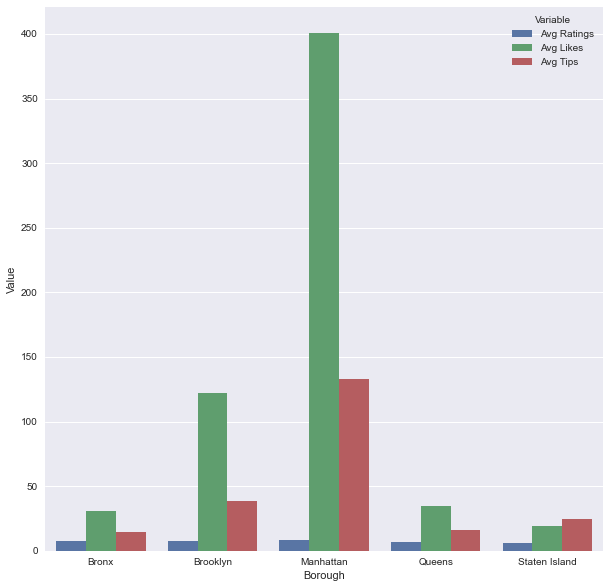

In [147]:
fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = df3.melt(id_vars='Borough').rename(columns=str.title)
sns.barplot(x='Borough', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)